In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Load the DPT model for depth estimation
from transformers import DPTForDepthEstimation, DPTImageProcessor

# Function to load an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

# Function to predict depth using DPT
def predict_depth(image):
    processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-base-384")
    model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-base-384")

    # Preprocess the image and make prediction
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert the output depth to a numpy array and normalize
    depth = outputs.predicted_depth.squeeze().cpu().numpy()
    depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))  # Normalize depth to [0, 1]
    return depth

# Function to create overlapping depth bins
def create_overlapping_depth_bins(depth_map, num_bins=5, overlap=0.2):
    depth_min = np.min(depth_map)
    depth_max = np.max(depth_map)
    bin_edges = np.linspace(depth_min, depth_max, num_bins + 1)

    # Create overlapping bins
    adjusted_bins = []
    for i in range(num_bins):
        start = max(depth_min, bin_edges[i] - overlap * (bin_edges[i + 1] - bin_edges[i]))
        end = min(depth_max, bin_edges[i + 1] + overlap * (bin_edges[i + 1] - bin_edges[i]))
        adjusted_bins.append((start, end))

    return adjusted_bins

# Function to segment the depth map into bins
def segment_depth_map(depth_map, bins):
    segmented_map = np.zeros_like(depth_map)
    for i, (start, end) in enumerate(bins):
        mask = (depth_map >= start) & (depth_map < end)
        segmented_map[mask] = i + 1  # Assign a unique label for each bin
    return segmented_map

# Function to visualize results
def visualize_results(original_image, depth_map, segmented_map):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show original image
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    
    # Show depth map
    axs[1].imshow(depth_map, cmap='inferno')
    axs[1].set_title("Depth Map")
    axs[1].axis("off")

    # Show segmented depth map
    axs[2].imshow(segmented_map, cmap='jet')
    axs[2].set_title("Segmented Depth Bins")
    axs[2].axis("off")

    plt.show()


/opt/homebrew/Caskroom/miniconda/base/envs/ssl-fede/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


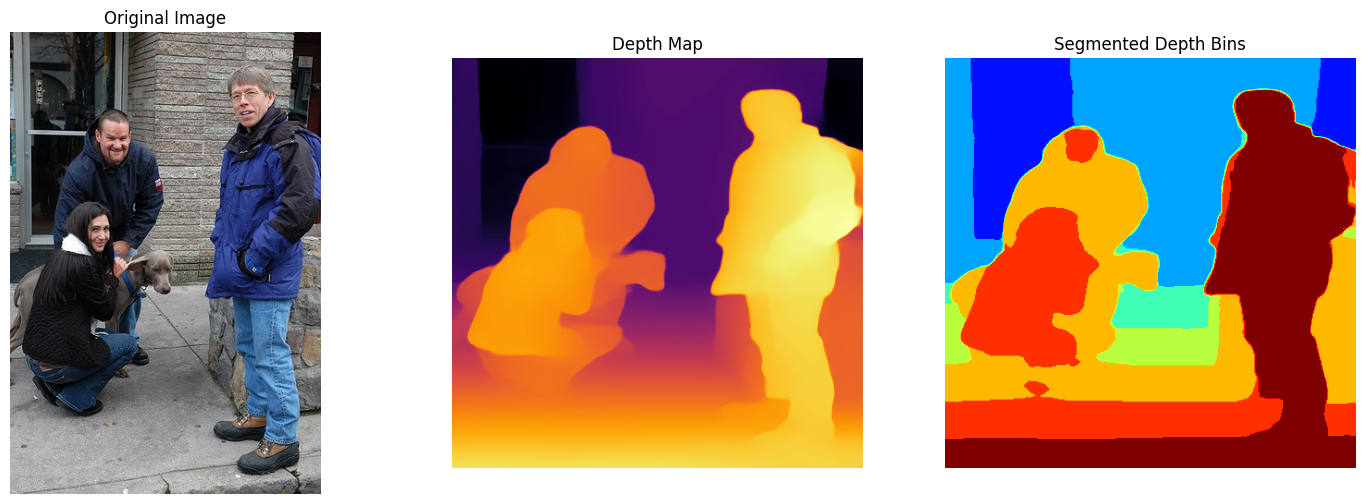

In [3]:
# Load your image
image_path = "datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/000021.jpg"
original_image = load_image(image_path)

# Predict depth
depth_map = predict_depth(original_image)

# Create overlapping depth bins
overlapping_bins = create_overlapping_depth_bins(depth_map, num_bins=7, overlap=0.2)

# Segment depth map into bins
segmented_depth_map = segment_depth_map(depth_map, overlapping_bins)

# Visualize the results
visualize_results(original_image, depth_map, segmented_depth_map)


[[2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


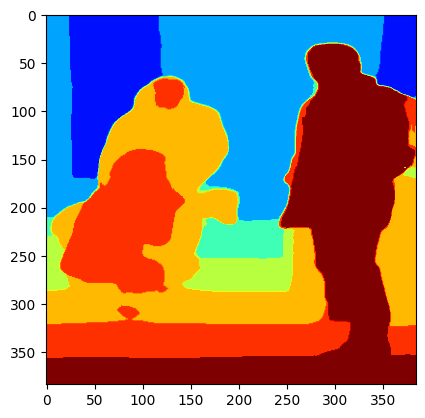

In [11]:
print(segmented_depth_map)
plt.imshow(segmented_depth_map, cmap='jet')
plt.show()

# att + dpeth bins

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Step 1: Define the function to create overlapping depth bins
def create_overlapping_depth_bins(depth_map, num_bins=5, overlap=0.2):
    depth_min = np.min(depth_map)
    depth_max = np.max(depth_map)
    bin_edges = np.linspace(depth_min, depth_max, num_bins + 1)

    bins = []
    for i in range(num_bins):
        start = max(depth_min, bin_edges[i] - overlap * (bin_edges[i + 1] - bin_edges[i]))
        end = min(depth_max, bin_edges[i + 1] + overlap * (bin_edges[i + 1] - bin_edges[i]))
        bins.append((start, end))
    return bins

# Step 2: Generate object proposals within each depth bin using attention
def get_proposals_in_bin(depth_map, attention_map, depth_range, attention_threshold=0.5):
    min_depth, max_depth = depth_range
    # Create a mask for the current depth range
    depth_mask = (depth_map >= min_depth) & (depth_map <= max_depth)
    
    # Apply the attention map to the depth mask
    attention_mask = attention_map > attention_threshold
    bin_mask = depth_mask & attention_mask
    
    # Find connected components in the mask to identify proposals
    num_labels, labels = cv2.connectedComponents(bin_mask.astype(np.uint8))
    
    # Extract proposals as regions
    proposals = []
    for label in range(1, num_labels):
        proposal_mask = (labels == label)
        y, x = np.where(proposal_mask)
        proposals.append((x, y))  # Store coordinates of each proposal

    return proposals

# Step 3: Merge proposals across overlapping bins
def merge_proposals_across_bins(all_bin_proposals):
    # For simplicity, merge proposals based on spatial proximity
    merged_proposals = []
    for proposals in all_bin_proposals:
        for proposal in proposals:
            merged_proposals.append(proposal)  # In practice, more sophisticated merging can be applied
    return merged_proposals

# Step 4: Visualization of proposals
def visualize_proposals(original_image, proposals):
    plt.imshow(original_image, cmap='gray')
    for proposal in proposals:
        x, y = proposal
        plt.scatter(x, y, s=1, color='red')
    plt.title("Object Proposals with Overlapping Depth Bins and Attention")
    plt.axis("off")
    plt.show()


In [34]:
# Load your image
image_path = "datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/009331.jpg"
original_image = load_image(image_path)


In [36]:
import torch
from torch import nn
from PIL import Image

from tqdm import tqdm

from myutils.depth import *
from myutils.dino1 import load_dino1_model
from myutils.dino2 import load_dino2_model
from myutils.discovery import *
from myutils.pascal_voc import *
from myutils.ssl import *
from myutils.utils import *
from myutils.datasets import bbox_iou

import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

from transformers import  DPTForDepthEstimation, DPTImageProcessor

import base64
import json
import argparse
from datetime import datetime

# dino v1
params = {
    'patch_size': 16,
    'ssl_checkpoint': 'pretrained/dino_deitsmall16_pretrain.pth',
#    'depth_checkpoint': 'Intel/dpt-hybrid-midas',
    'depth_checkpoint': 'Intel/dpt-beit-base-384',
    'img_size': None
}

# dino v2
#params = {
#    'patch_size': 14,
#    'ssl_checkpoint': 'pretrained/dinov2_vits14_reg4_pretrain.pth',
#    'depth_checkpoint': 'Intel/dpt-beit-base-384',
#    'img_size': 526
#}

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read an image
pil_img = load_image_as_pil(image_path)

# Convert to tensor and transform
img_tensor = load_image_as_tensor(pil_img).to(device)

#########################
# GETTING THE ATTENTION #
#########################

# Padding the image with zeros to fit multiple of patch-size
patch_size = params['patch_size']
img_paded = img_tensor_padded(img_tensor, patch_size).to(device)

# Load the SSL model
model = load_dino1_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
#model = load_dino2_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
model.to(device)
model.eval()

# Get the attentions
atts = get_attentions(model, img_paded, patch_size)

attention_map = atts.max(0)


In [37]:
# Predict depth
depth_map = predict_depth(original_image)


In [38]:
# Resize attention map to match depth map dimensions
resized_attention_map = cv2.resize(attention_map, (depth_map.shape[1], depth_map.shape[0]), interpolation=cv2.INTER_LINEAR)


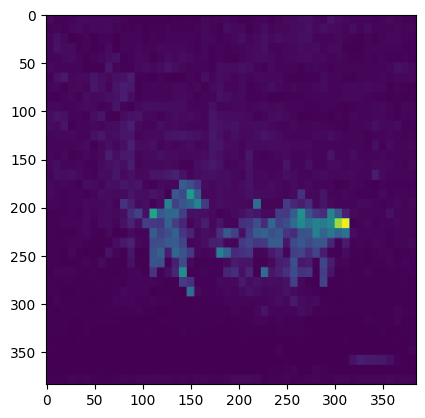

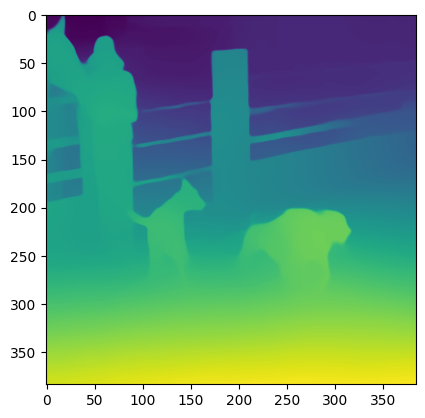

ValueError: too many values to unpack (expected 2)

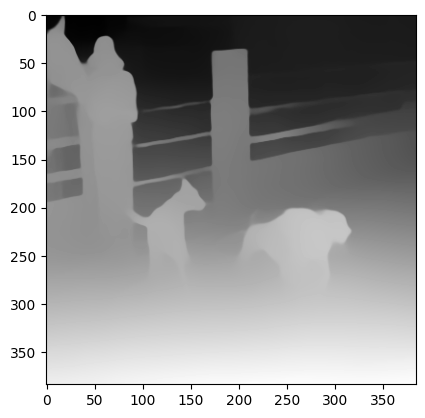

In [39]:

# Step 1: Create overlapping depth bins
overlapping_bins = create_overlapping_depth_bins(depth_map, num_bins=5, overlap=0.2)

plt.imshow(resized_attention_map)
plt.show()

plt.imshow(depth_map)
plt.show()

# Let's separate the segmented_depth_map into layers
depth_layers = []

for i, bin in enumerate(overlapping_bins):
    mask = (segmented_depth_map == i)
    depth_layer = np.where(mask, depth_map, 0)
    depth_layers.append(depth_layer)

# Step 2: Generate proposals in each depth bin
#all_bin_proposals = []
#for depth_range in overlapping_bins:
#    proposals = get_proposals_in_bin(depth_map, resized_attention_map, depth_range, attention_threshold=0.5)
#    all_bin_proposals.append(proposals)

# Step 3: Merge proposals across overlapping bins
merged_proposals = merge_proposals_across_bins(depth_layers)

# Step 4: Visualize results
visualize_proposals(depth_map, merged_proposals)
